# Magnetic Range of Influence (MRoI)
This routine generates a map of the Magnetic Range of Influence (MRoI) for a synoptic chart of radial magnetic flux density input in a sine-latitude coordinate system. This is a measure of the distance required to integrate from a given pixel to neutralize the magnetic flux within.

For more details see the paper by McIntosh+ 2006.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
from astropy.io import fits

In [2]:
datadir = '/Users/clowder/data/'
filename = datadir + 'hmi.Synoptic_Mr.polfil/hmi.synoptic_mr_polfil_720s.2283.Mr_polfil.fits'

with fits.open(filename) as hdul:
    br0 = hdul[1].data

br = scipy.ndimage.zoom(br0, 0.05)

In [3]:
def gen_gcmap(lat, lon, lats, lons):
    '''
    Generates a great circle distance map for a specified coordinate and sine-latitude map
    Input latitude is specified in sine-latitude
    '''
    # Define constants and coordinates
    rsun = 6.957e10 #cm
    mlons, mlats = np.meshgrid(lons, lats)

    # Generate the great circle distance map
    gcmap = rsun * np.arccos(mlats*lat + np.cos(np.arcsin(mlats))*np.cos(np.arcsin(lat))*np.cos(np.abs(mlons-lon)))
 
    return gcmap

def gen_mroi(br):

    # Define the coordinate system
    lats = np.linspace(-1, 1, br.shape[0])
    lons = np.linspace(0, 2*np.pi, br.shape[1])

    # Compute an empty array to store MRoI values
    mroi = np.zeros(br.shape)

    # Move along through the coordinates and compute MRoI
    for ilat in np.arange(lats.shape[0]):
        for ilon in np.arange(lons.shape[0]):

            # Compute a great cicle distance map
            #   and distance list
            gcmap = gen_gcmap(lats[ilat], lons[ilon], lats, lons)
            dvals = np.unique(gcmap)

            # Integrate flux outward in distance until neutralized
            oflux = br[ilat, ilon]
            iflux = oflux
            r0 = 0
            for d in dvals[1:]:
                wdr = np.where(np.logical_and((gcmap > r0),(gcmap <= d)))
                iflux += br[wdr].sum()
                r0 = d      # Distance assigned post balance
                if ( np.sign(iflux) != np.sign(oflux) ): break

            # Assign this computed value of MRoI
            mroi[ilat, ilon] = r0

    return mroi

In [4]:
mroi = gen_mroi(br)
np.save('mroi.npy', mroi)

# mroi = np.load('mroi.npy')

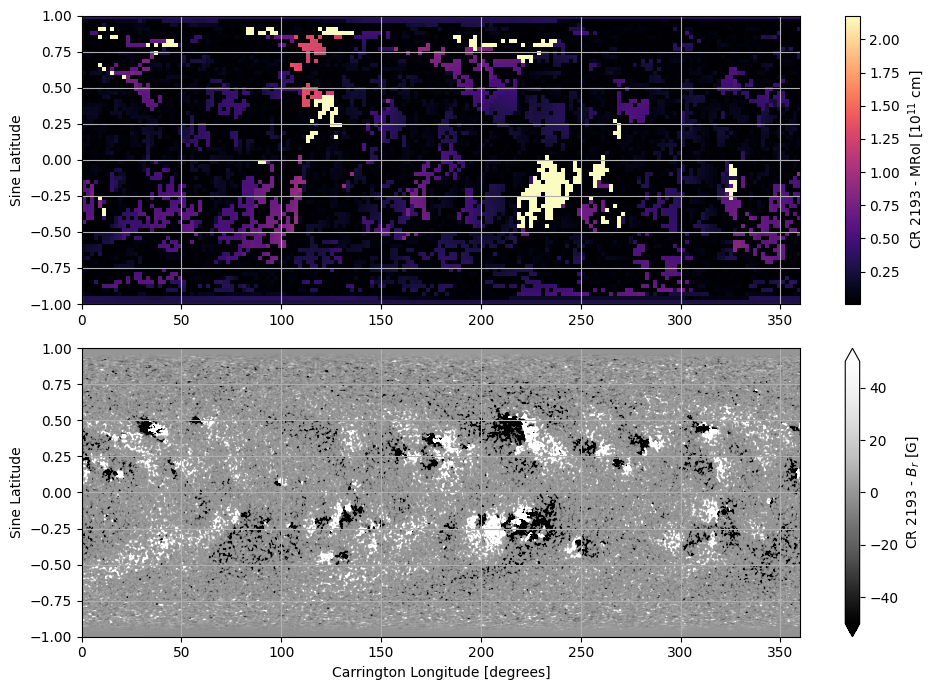

In [5]:
f, (ax1,ax2) = plt.subplots(2, figsize=[10,7])
im1 = ax1.imshow(mroi/1e11, extent=[0,360,-1,1], aspect='auto')
cb1 = plt.colorbar(im1, ax=ax1, label='CR 2193 - MRoI [10$^{11}$ cm]')
ax1.set_ylabel('Sine Latitude')
im2 = ax2.imshow(br0, extent=[0,360,-1,1], aspect='auto', vmin=-50, vmax=50, cmap='Greys_r')
cb2 = plt.colorbar(im2, ax=ax2, label='CR 2193 - $B_r$ [G]', extend='both')
ax2.set_xlabel('Carrington Longitude [degrees]')
ax2.set_ylabel('Sine Latitude')
ax1.grid()
ax2.grid()
plt.tight_layout()